In [1]:
!pip install tensorflow-gpu==2.0.0-alpha0
!pip install tfp-nightly

     |████████████████████████████████| 332.1MB 60kB/s 
     |████████████████████████████████| 419kB 43.4MB/s 
     |████████████████████████████████| 61kB 22.1MB/s 
     |████████████████████████████████| 3.0MB 33.0MB/s 
     |████████████████████████████████| 972kB 2.7MB/s 


In [0]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

import tensorflow_probability as tfp
tfd = tfp.distributions

%matplotlib inline



### additional material

https://www.youtube.com/watch?v=BrwKURU-wpk  

https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf

In [3]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

In [0]:
lala=tfd.Normal(loc=5,scale=6)

In [5]:
lala.log_prob(np.array([3,5,7]))

<tf.Tensor: id=11, shape=(3,), dtype=float32, numpy=array([-2.7662537, -2.7106981, -2.7662537], dtype=float32)>

In [0]:

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
  np.random.seed(43)
  def s(x):
    g = (x - x_range[0]) / (x_range[1] - x_range[0])
    return 3 * (0.25 + g**2.)
  x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
  eps = np.random.randn(n) * s(x)
  y = (w0 * x * (1. + np.sin(x)) + b0) + eps
  x = x[..., np.newaxis]
  x_tst = np.linspace(*x_range, num=n_tst).astype(np.float32)
  x_tst = x_tst[..., np.newaxis]
  return y, x, x_tst

y, x, x_tst = load_dataset()

In [212]:
print(x.shape)
print(y.shape)
print(x_tst.shape)

(150, 1)
(150,)
(150, 1)


In [0]:
#x sind randmon zahlen zwischen -20 und 60
#x test ist der range in 150 schrtten von -20 +60 
#y = (w0 * x * (1. + np.sin(x)) + b0) + eps

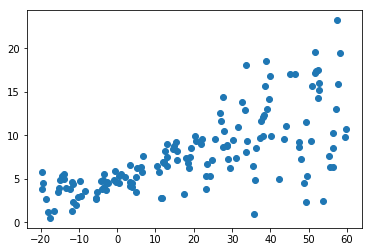

In [214]:
plt.scatter(x,y)

### ML Estimator


In [215]:
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [0.13523116]
Coefficients: 
 5.128420601457348


In [155]:
#Build model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape=(1,)))
model.compile(loss='mse', optimizer="adam", metrics=['accuracy'])
model.summary()
model.fit(x,y,batch_size=150,epochs=12000,verbose=0)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [156]:
model.get_weights()

[array([[0.10309654]], dtype=float32), array([4.8094215], dtype=float32)]

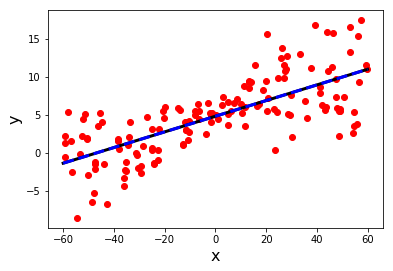

In [157]:
plt.scatter(x,y,color="red") #observerd 
plt.plot(x_tst,model.predict(x_tst),color="black",linewidth=3) #pred
plt.plot(x_tst,a_ml*x_tst+b_ml,color="blue",linewidth=3,linestyle="--") #pred
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)#pred
plt.show()
#plt.scatter(x_tst,model.predict(x_tst)-2,color="blue") 
#plt.scatter(x_tst,model.predict(x_tst)+2,color="blue") 

In [158]:
print(model.predict(x_tst)[0:3])
np.random.normal(loc=model.predict(x_tst)[0:3],scale=1)

[[-1.3763714]
 [-1.2933402]
 [-1.2103095]]


array([[-3.07217991],
       [ 0.02044926],
       [-1.02976364]])

## No UnC but dist as output with constant variance

In [0]:
#negloglik = lambda y, rv_y: -rv_y.log_prob(y)#define negative loglike
def negloglik(y,rv_y):
  return -rv_y.log_prob(y)

In [0]:
def dumm(t):
  return tfd.Normal(loc=t, scale=1)

In [161]:
#Build model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(1,input_shape=(1,)))
#model.add(tfp.layers.DistributionLambda(lambda t1: tfd.Normal(loc=t1, scale=1)))
model.add(tfp.layers.DistributionLambda(dumm))
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=0)
#model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 2         
_________________________________________________________________
distribution_lambda_15 (Dist ((None, 1), (None, 1))    0         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [162]:
model.get_weights()

[array([[0.10389427]], dtype=float32), array([4.801586], dtype=float32)]

In [0]:
#model.predict(x_tst[0:3])
#model

In [164]:
print(model(x_tst[0:3]).stddev())
print(model(x_tst[0:3]).mean())
print(model(x_tst[0:3]).sample())


tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[-1.4320703]
 [-1.3483968]
 [-1.2647238]], shape=(3, 1), dtype=float32)
tf.Tensor(
[[-1.8355598]
 [-1.5420715]
 [-2.166197 ]], shape=(3, 1), dtype=float32)


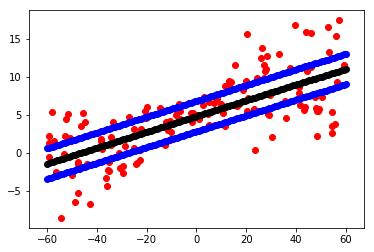

In [165]:
plt.scatter(x,y,color="red") 
plt.scatter(x_tst,model(x_tst).mean(),color="black")
plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
#plt.scatter(x,y,color="red") #observerd 
##for i in range(0,1):
##  plt.scatter(x_tst,model(x_tst).sample())
#plt.scatter(x_tst,model(x_tst).mean(),color="black")
#plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
#plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
#model(x_tst).prob(5).numpy()#prob for x test 5 to habe the value 5

### Case 2: Aleatoric Uncertainty

In [0]:
#x=np.arange(-10,10,1)
#y1= tf.math.softplus(0.05*y)
#y2=np.log(1 + np.exp(x))
#plt.scatter(x,y1)
##plt.scatter(x,y2)

In [169]:

#Build model.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2,input_shape=(1,)))
model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],
                                                              scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2]))))
### neu ist das softplus nun wird var mit modelliert)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)




Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 4         
_________________________________________________________________
distribution_lambda_16 (Dist ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x, y, epochs=2000, verbose=False);


In [171]:
model.get_weights()

[array([[0.10193642, 0.07108275]], dtype=float32),
 array([ 4.8207197, 19.902994 ], dtype=float32)]

In [172]:
print(model(x_tst[0:1]).mean())
print(model(x_tst[0:1]).stddev())

tf.Tensor([[-1.2954655]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.1596483]], shape=(1, 1), dtype=float32)


In [173]:
print(x_tst[0:1]*0.12251923+5.202958)
print(tf.math.softplus(0.05*(x_tst[0:1]*1.0129702 +16.956917)))

[[-2.1481957]]
tf.Tensor([[0.10597824]], shape=(1, 1), dtype=float32)


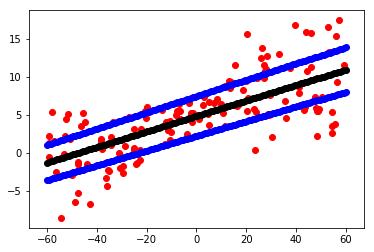

In [174]:
plt.scatter(x,y,color="red") #observerd 
#for i in range(0,3):
 # plt.scatter(x_tst,model(x_tst).sample())
plt.scatter(x_tst,model(x_tst).mean(),color="black")
plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

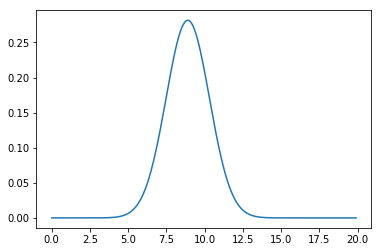

In [175]:
lala=np.arange(0,20,0.1)
lala2= model(np.array([[40]])).prob(lala)
lala2= lala2.numpy()
lala2= lala2.reshape(200,)
plt.plot(lala,lala2)

### Case 3: Epistemic Uncertainty

In [176]:
#Build model.
model = tf.keras.Sequential()
model.add(tfp.layers.DenseFlipout(1,
                                  bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                                  bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                                  input_shape=(1,),))
model.add(tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t,scale=1)))
#model.add(tf.keras.layers.Dense(1))
#weights haben nun eine dist und output ist auch eine dist mit konst sd=1
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)




Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_flipout_5 (DenseFlipou (None, 1)                 4         
_________________________________________________________________
distribution_lambda_17 (Dist ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [177]:
model.fit(x, y, epochs=3000, verbose=0)


In [178]:
model.get_weights()

[array([[0.10221417]], dtype=float32),
 array([[-3.6405485]], dtype=float32),
 array([2.3782103], dtype=float32),
 array([0.07646347], dtype=float32)]

In [179]:
model(x_tst).mean()

<tf.Tensor 'mul_13:0' shape=(150, 1) dtype=float32>

In [180]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
xx = tfp.layers.DenseFlipout(1,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(inputs)

predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t,scale=1))(xx)

model = Model(inputs=inputs, outputs=predictions)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout_6 (DenseFlipou (None, 1)                 4         
_________________________________________________________________
distribution_lambda_18 (Dist ((None, 1), (None, 1))    0         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(x, y,batch_size=32 ,epochs=2000, verbose=0)


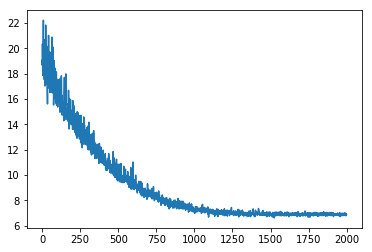

In [182]:
plt.plot(history.history['loss'])

In [183]:
model.get_weights()

[array([[0.10307179]], dtype=float32),
 array([[-5.2208743]], dtype=float32),
 array([4.7725153], dtype=float32),
 array([-2.515238], dtype=float32)]

In [0]:
model_mean = tf.keras.models.Model(inputs=inputs, outputs=predictions.mean())
model_std = tf.keras.models.Model(inputs=inputs, outputs=predictions.stddev())

In [185]:
model_mean.get_weights()

[array([[0.10307179]], dtype=float32),
 array([[-5.2208743]], dtype=float32),
 array([4.7725153], dtype=float32),
 array([-2.515238], dtype=float32)]

In [186]:
for i in range(0,5):
  print(model_mean.predict(x_tst[0:1]))

[[-1.195118]]
[[-1.4717526]]
[[-1.6469083]]
[[-1.1452379]]
[[-1.2938633]]


In [187]:
!pip install tqdm
from tqdm import tqdm_notebook as tqdm



In [188]:
n=10000
n_preds=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model_mean.predict(x_tst,batch_size=150),150)

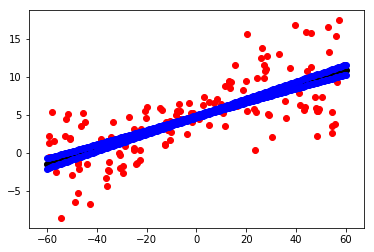

In [189]:
plt.scatter(x,y,color="red") #observerd 
plt.scatter(x_tst,np.mean(n_preds,axis=0),color="black")
plt.scatter(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="blue")
plt.scatter(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="blue")

### Case 4: Aleatoric and Epistemic Uncertainty

In [216]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


# This returns a tensor
inputs = Input(shape=(1,))

# a layer instance is callable on a tensor, and returns a tensor
xx = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
xx = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(xx)

predictions = tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[:, 0:1],scale=1e-3 + tf.math.softplus(0.05 * t[:,1:2])))(xx)


model = Model(inputs=inputs, outputs=predictions)
model.summary()
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(), loss=negloglik)

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout_10 (DenseFlipo (None, 20)                80        
_________________________________________________________________
dense_flipout_11 (DenseFlipo (None, 2)                 84        
_________________________________________________________________
distribution_lambda_21 (Dist ((None, 1), (None, 1))    0         
Total params: 164
Trainable params: 164
Non-trainable params: 0
_________________________________________________________________


In [0]:
history=model.fit(x, y,batch_size=32 ,epochs=2000, verbose=0)


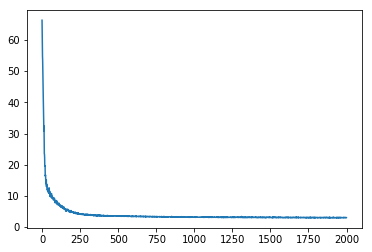

In [218]:
plt.plot(history.history['loss'])

In [219]:
model.get_weights()

[array([[-0.7546113 , -0.01493009,  0.63730824, -0.00333593,  0.06886515,
          0.03181116, -0.01830751, -0.05257435, -0.51756966, -0.05049763,
          0.7153774 , -0.04068408, -0.06109449, -0.05980483, -0.02712224,
         -0.05590111, -0.08047739,  0.30844358, -0.06479267, -0.03851845]],
       dtype=float32),
 array([[-1.2632126, -4.111443 , -1.7418197, -1.7007492, -1.5917016,
         -4.522742 , -1.9994621, -2.2200582, -1.4254278, -2.3375404,
         -1.851145 , -2.543763 , -1.407182 , -2.1738198, -1.6662141,
         -2.0701559, -1.683442 , -3.6373587, -2.3694003, -2.3927736]],
       dtype=float32),
 array([-1.15568429e-01,  1.40522993e+00,  5.47378650e-03, -6.66406229e-02,
        -7.13294894e-02,  1.88388324e+00,  1.76860322e-03, -4.55901414e-01,
        -1.54890403e-01, -5.24404824e-01,  3.14156041e-02, -5.02284646e-01,
        -1.20876536e-01, -3.93959135e-01, -2.51644291e-02, -3.34167540e-01,
        -1.67716041e-01,  1.60626149e+00, -5.30593336e-01, -1.61773786e-01

In [0]:
model_mean = tf.keras.models.Model(inputs=inputs, outputs=predictions.mean())
model_std = tf.keras.models.Model(inputs=inputs, outputs=predictions.stddev())

In [221]:
model_mean.get_weights()

[array([[-0.7546113 , -0.01493009,  0.63730824, -0.00333593,  0.06886515,
          0.03181116, -0.01830751, -0.05257435, -0.51756966, -0.05049763,
          0.7153774 , -0.04068408, -0.06109449, -0.05980483, -0.02712224,
         -0.05590111, -0.08047739,  0.30844358, -0.06479267, -0.03851845]],
       dtype=float32),
 array([[-1.2632126, -4.111443 , -1.7418197, -1.7007492, -1.5917016,
         -4.522742 , -1.9994621, -2.2200582, -1.4254278, -2.3375404,
         -1.851145 , -2.543763 , -1.407182 , -2.1738198, -1.6662141,
         -2.0701559, -1.683442 , -3.6373587, -2.3694003, -2.3927736]],
       dtype=float32),
 array([-1.15568429e-01,  1.40522993e+00,  5.47378650e-03, -6.66406229e-02,
        -7.13294894e-02,  1.88388324e+00,  1.76860322e-03, -4.55901414e-01,
        -1.54890403e-01, -5.24404824e-01,  3.14156041e-02, -5.02284646e-01,
        -1.20876536e-01, -3.93959135e-01, -2.51644291e-02, -3.34167540e-01,
        -1.67716041e-01,  1.60626149e+00, -5.30593336e-01, -1.61773786e-01

In [222]:
for i in range(0,5):
  print(model_mean.predict(x_tst[0:1]))

[[6.3516603]]
[[3.6550794]]
[[1.5687373]]
[[0.6888957]]
[[4.2781773]]


In [223]:
n=10000
n_preds=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds[i,:]=np.reshape(model_mean.predict(x_tst,batch_size=150),150)

In [224]:
n=10000
n_preds_std=np.zeros((n,len(x_tst)))
for i in tqdm(range(0,n)):
  n_preds_std[i,:]=np.reshape(model_std.predict(x_tst,batch_size=150),150)

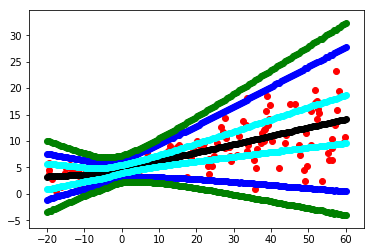

In [225]:
plt.scatter(x,y,color="red") #observerd 
plt.scatter(x_tst,np.mean(n_preds,axis=0),color="black")
plt.scatter(x_tst,np.mean(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="blue")
plt.scatter(x_tst,np.mean(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="blue")
plt.scatter(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0),color="cyan")
plt.scatter(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0),color="cyan")
plt.scatter(x_tst,np.mean(n_preds,axis=0)+2*np.std(n_preds,axis=0)+2*np.mean(n_preds_std,axis=0),color="green")
plt.scatter(x_tst,np.mean(n_preds,axis=0)-2*np.std(n_preds,axis=0)-2*np.mean(n_preds_std,axis=0),color="green")

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n*2, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])

In [0]:
# Build model.
model = tf.keras.Sequential([
tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable,input_shape=(1,),activation="relu"),
  #tfp.layers.DenseVariational(10, posterior_mean_field, prior_trainable),
  #tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
  #tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1)),
])

# Do inference.
model.summary()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)


NameError: ignored

In [0]:
#from IPython.display import SVG
#SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
#from keras.utils.vis_utils import model_to_dot
#

In [0]:
model(x_tst[0:1]).stddev()

<tf.Tensor: id=1055749, shape=(1, 1), dtype=float32, numpy=array([[1.]], dtype=float32)>

In [0]:
model.fit(x, y, epochs=1000, verbose=False);



In [0]:
# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
#yhat = model(x_tst)
#assert isinstance(yhat, tfd.Distribution)

[ 0.15286246  4.7040496  -3.66455    -0.52826744]
[0.13826916 4.6131687 ]


In [0]:
model.get_weights()#mitelwert von steigung und intercept und noch dazue die standartabweichung beide sind normalverteilt

[array([ 0.15286246,  4.7040496 , -3.66455   , -0.52826744], dtype=float32),
 array([0.13826916, 4.6131687 ], dtype=float32)]

In [0]:
#model(x_tst).mean()

In [0]:
#model(x_tst).stddev()

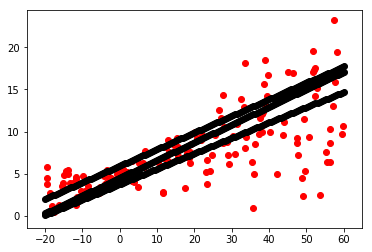

In [0]:
plt.scatter(x,y,color="red") #observerd 
#for i in range(0,3):
  #plt.scatter(x_tst,model(x_tst).sample())
for i in range(0,3):
  plt.scatter(x_tst,model(x_tst).mean(),color="black")
  #plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
  #plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
#model(x_tst).mean()

### Case 4: Aleatoric & Epistemic Uncertainty

In [0]:
# Build model.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(2, posterior_mean_field, prior_trainable,input_shape=(1,)),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

# Do inference.
model.summary()
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_18 (DenseV (None, 2)                 12        
_________________________________________________________________
distribution_lambda_31 (Dist ((None, 1), (None, 1))    0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.fit(x, y, epochs=1000, verbose=False);


In [0]:

# Profit.
[print(np.squeeze(w.numpy())) for w in model.weights];
#yhat = model(x_tst)
#assert isinstance(yhat, tfd.Distribution)

[ 0.12944002  2.4189117   5.1540465   2.7859828  -3.2581356  -0.65550274
 -0.56626487 -0.02603184]
[0.14465801 2.3947232  5.172522   2.651446  ]


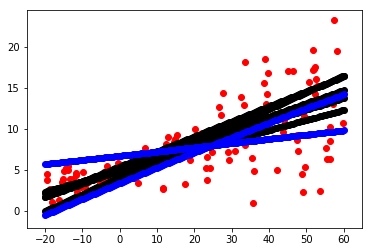

In [0]:
plt.scatter(x,y,color="red") #observerd 
#for i in range(0,3):
  #plt.scatter(x_tst,model(x_tst).sample())
for i in range(0,5):
  plt.scatter(x_tst,model(x_tst).mean(),color="black")
plt.scatter(x_tst,model(x_tst).mean()+2*model(x_tst).stddev(),color="blue")
plt.scatter(x_tst,model(x_tst).mean()-2*model(x_tst).stddev(),color="blue")

In [0]:
model(x_tst).prob(5)

<tf.Tensor: id=482737, shape=(150, 1), dtype=float32, numpy=
array([[0.04425406],
       [0.05308542],
       [0.06296034],
       [0.07387467],
       [0.08580549],
       [0.09871055],
       [0.11252999],
       [0.12718761],
       [0.14259255],
       [0.15864196],
       [0.17522314],
       [0.19221663],
       [0.20949847],
       [0.22694321],
       [0.24442582],
       [0.26182547],
       [0.27902502],
       [0.2959148 ],
       [0.31239295],
       [0.32836694],
       [0.3437542 ],
       [0.35848224],
       [0.37248957],
       [0.38572463],
       [0.3981473 ],
       [0.40972653],
       [0.42044085],
       [0.43027762],
       [0.4392323 ],
       [0.4473077 ],
       [0.45451325],
       [0.46086413],
       [0.46638042],
       [0.47108632],
       [0.47501034],
       [0.47818303],
       [0.48063767],
       [0.48240882],
       [0.48353267],
       [0.48404598],
       [0.48398572],
       [0.48338884],
       [0.48229215],
       [0.4807313 ],
       [0.47874